# **Norway data**

Running this notebook does not require a GPU. You can use a frontal node. However, certain parts such as detecting bounding boxes or removing the background from images require GPUs which are launched in external jobs.

In [4]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [5]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path

from lynx_id.utils.preprocess.utils import check_filepath, flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

In [6]:
# GPU parameters for jobs to be launched (MegaDetector + SAM)
MODULE = 'pytorch-gpu/py3/2.2.0'
account = 'ads@v100'

In [7]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")
COUNTRY = "norway"
NORWAY_DATASET_PATH = DATASET / "norway" / "Zoo data_Thorsen"
NO_BACKGROUND = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new")

---

## **Get images (filepath + lynx_id)**

In [8]:
dataset_dict = {
    "filepath": [],
    "lynx_id": [],
}

In [9]:
translation = {
    "Vinter": "Winter",
    "Sommer": "Summer",
    "Dag": "Day",
    "IR": "IR",
    "LED": "Dark",
    "Venstre": "Left",
    "Høyre": "Right"
}  # if one day there is a need for other elements

def parse_filename(filename):
    parts = filename.split("/norway/Zoo data_Thorsen/")[1:][0].split("/")
    
    return {"id_lynx": parts[0]}

In [10]:
for current_directory, _, files in os.walk(NORWAY_DATASET_PATH):
    for file in files:
        absolute_path = os.path.abspath(os.path.join(current_directory, file))
        if re.compile(r'\.(jpg|jpeg|png)$', re.IGNORECASE).search(absolute_path):

            try:
                parsed = parse_filename(absolute_path)
                dataset_dict["filepath"].append(absolute_path)
                dataset_dict["lynx_id"].append(parsed["id_lynx"])

            except:
                print(f"Error with: {absolute_path}")

In [11]:
df_country = pd.DataFrame(dataset_dict)
df_country

,filepath,lynx_id
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1
...,...,...
11502,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 6
11503,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 6
11504,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 6
11505,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 6


In [12]:
df_country.nunique()

filepath    11507
lynx_id        28
dtype: int64

### **Deleting broken images**

In [13]:
all_files_exist = all(df_country['filepath'].apply(os.path.exists))
all_files_exist

True

## **Bounding box detection**

In [14]:
country_output_megadetector = DATASET / COUNTRY / f"bbox_{COUNTRY}.json"  # WARNING: change filename if needed
country_output_megadetector

PosixPath('/gpfsscratch/rech/ads/commun/datasets/extracted/norway/bbox_norway.json')

In [15]:
image_filenames = df_country['filepath'].tolist()
len(image_filenames)

11507

In [16]:
# Bounding box calculation is externalised to another job
image_filenames_path = f"image_filenames_{COUNTRY}.txt"
with open(image_filenames_path, 'w') as f:
    json.dump(image_filenames, f)

n_gpu = 1
command = f'run_megadetector.py --image_filenames_path {image_filenames_path} --output_megadetector {country_output_megadetector}'

jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=f"megadetector_{COUNTRY}",
                   account=account, time_max='04:00:00', constraint='v100-32g', qos='qos_gpu-t3')
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 10 cpus per task
Submitted batch job 326518
jobid = ['326518']


In [17]:
display_slurm_queue(name=f"megadetector_{COUNTRY}", timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            326518   gpu_p13 megadete  uxp55sd  R      18:14      1 r6i2n6

 Done!


In [18]:
with open(country_output_megadetector, 'r') as f:
    bbox_country = json.load(f)

Some images may not have bounding boxes found.

In [19]:
no_bbox_country, multiple_bbox_country = get_no_and_multiple_bbox(bbox_country)

1437 images have no bounding boxes detected.
388 images have several bounding boxes detected.
Total: 11507 images.


Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [20]:
df_bbox_country = flatten_bbox(bbox_country, add_image_without_bbox=False, verbose=False)
df_bbox_country = absolute_coordinates_bbox(df_bbox_country)

df_bbox_country

,file,im_width,im_height,category,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1440,1,0.963,0.000000,458.9280,934.9120,686.8800
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1440,1,0.960,0.000000,99.9936,788.8896,932.9760
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,1,0.921,1507.942400,586.9056,539.8528,336.9984
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,3,0.945,0.000000,444.9792,395.8784,333.9264
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,1,0.927,1109.811200,586.9056,403.8656,270.9504
...,...,...,...,...,...,...,...,...,...
10562,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1440,1,0.882,911.974400,361.8720,286.9248,345.8880
10563,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1440,1,0.868,17.999872,607.9680,388.9152,189.9360
10564,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1440,1,0.924,896.000000,380.8800,311.9104,322.9920
10565,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1440,1,0.847,377.856000,619.9200,327.8848,149.9040


In [21]:
df_bbox_country.nunique()['file']

10070

### **10 images cropped with the least confidence are displayed**

Only images with a single bounding box are displayed.

In [22]:
df_bbox_country_single_detection, df_bbox_country_multiple_detections = separate_single_multiple_df(df_bbox_country)

print(len(df_bbox_country_single_detection))
print(len(df_bbox_country_multiple_detections))

9682
885


In [23]:
%matplotlib inline

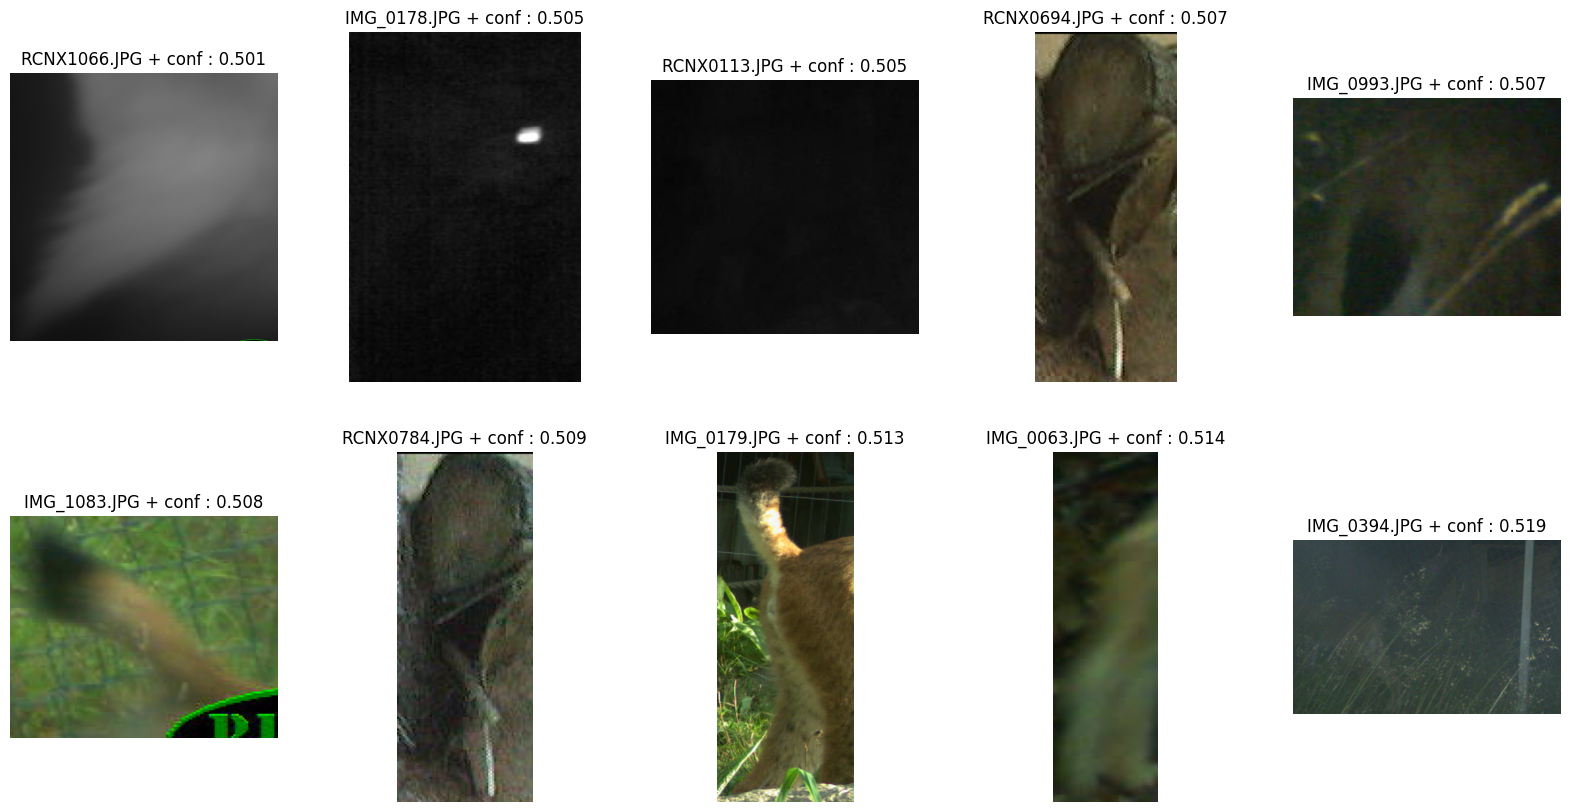

In [24]:
plot_images_conf(df_bbox_country_single_detection, by="smallest")

### **10 images cropped with the largest confidence are displayed**

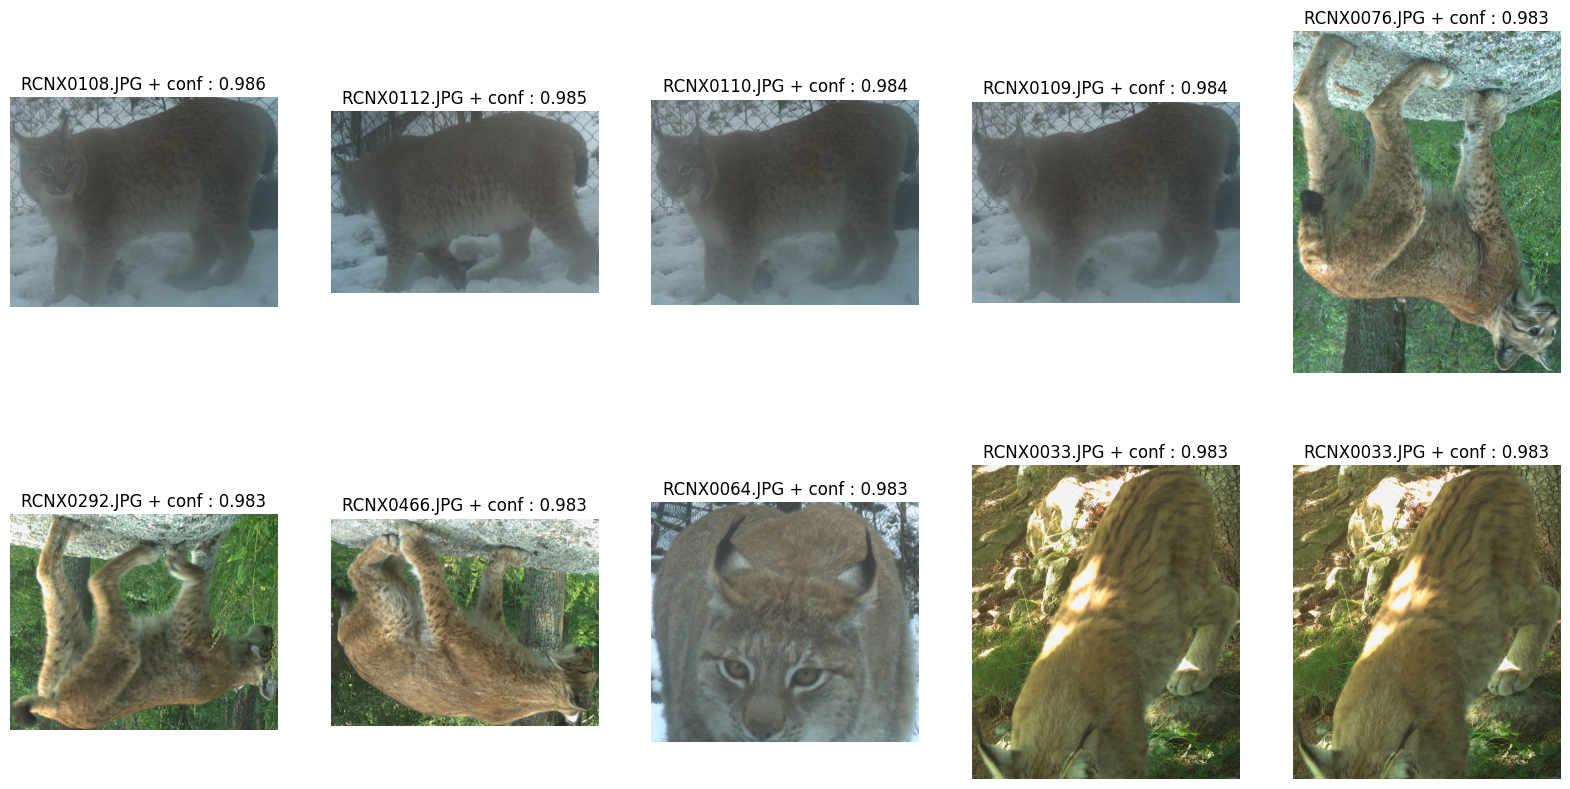

In [25]:
plot_images_conf(df_bbox_country_single_detection, by="largest")

In [26]:
df_country_with_bbox = pd.merge(df_country, df_bbox_country_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_country_with_bbox = df_country_with_bbox.drop('file', axis=1)

df_country_with_bbox

,filepath,lynx_id,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.963,0.0000,458.9280,934.9120,686.880
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.960,0.0000,99.9936,788.8896,932.976
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.892,303.9232,770.9184,267.8784,218.880
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.793,0.0000,607.9488,404.8896,334.848
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.872,0.0000,869.9040,301.8752,187.920
...,...,...,...,...,...,...,...
9677,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nordens 2,0.961,1451.8272,363.8880,314.9824,273.888
9678,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nordens 2,0.936,1282.8672,372.9600,366.7968,300.960
9679,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nordens 2,0.922,784.9984,522.0000,491.9296,196.992
9680,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nordens 2,0.954,1239.8592,369.9360,413.9008,312.912


#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

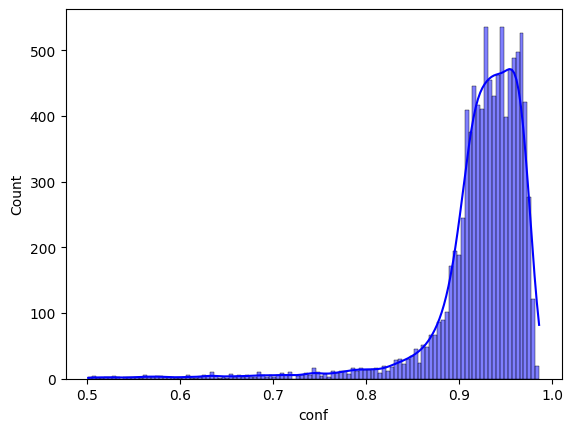

In [27]:
import seaborn as sns

sns.histplot(df_country_with_bbox["conf"], kde=True, color='blue')

## **Compute `image_number` for each individual**

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [28]:
df_country_with_bbox['image_number'] = df_country_with_bbox.groupby('lynx_id').cumcount() + 1
df_country_with_bbox

,filepath,lynx_id,conf,x,y,width,height,image_number
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.963,0.0000,458.9280,934.9120,686.880,1
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.960,0.0000,99.9936,788.8896,932.976,2
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.892,303.9232,770.9184,267.8784,218.880,3
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.793,0.0000,607.9488,404.8896,334.848,4
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Lang 1,0.872,0.0000,869.9040,301.8752,187.920,5
...,...,...,...,...,...,...,...,...
9677,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nordens 2,0.961,1451.8272,363.8880,314.9824,273.888,279
9678,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nordens 2,0.936,1282.8672,372.9600,366.7968,300.960,280
9679,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nordens 2,0.922,784.9984,522.0000,491.9296,196.992,281
9680,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nordens 2,0.954,1239.8592,369.9360,413.9008,312.912,282


## **Add other information**

In [29]:
needed_columns = ['source', 'pattern', 'date', 'location']
for col in needed_columns:
    if col not in df_country_with_bbox.columns:
        df_country_with_bbox[col] = np.nan

In [30]:
df_country_with_bbox['country'] = COUNTRY

In [31]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

## **Remove backgrounds**

Images without backgrounds are calculated using the `Segment Anything Model`. These are saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/no_background`.  
The csv file is completed with a `filepath_no_bg` column and saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_no_bg.csv`

In [7]:
df_country_with_bbox = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

### **Add the `filepath_no_bg` column based on existing images**

In [8]:
df_country_with_bbox['filepath_no_bg'] = df_country_with_bbox.apply(lambda row: check_filepath(NO_BACKGROUND, COUNTRY, row['filepath'], row['lynx_id'], row['image_number']), axis=1)

In [9]:
print(f"Number of images remaining to be calculated: {df_country_with_bbox['filepath_no_bg'].isna().sum()}")

Number of images remaining to be calculated: 9682


In [10]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

In [ ]:
display_slurm_queue(name=f'sam_{COUNTRY}', timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            350870   gpu_p13 sam_norw  uxp55sd  R      32:47      1 r9i1n2


In [8]:
df_full = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [9]:
df_full.groupby('country').nunique()[['filepath', 'filepath_no_bg']]

,filepath,filepath_no_bg
country,,
norway,9682,9682


In [10]:
all_files_exist = df_full['filepath_no_bg'].apply(lambda x: pd.isna(x) or os.path.exists(x)).all()
assert all_files_exist

In [11]:
df_full.shape

(9682, 15)

In [13]:
df_full.loc[df_full['filepath_no_bg'].str.contains('no_bg_1659_IMG_1083.JPG')]

,filepath,lynx_id,conf,x,y,width,height,image_number,source,pattern,date,location,country,filepath_no_bg,score_sam
4492,/gpfsscratch/rech/ads/commun/datasets/extracte...,Orsa 1,0.508,1739.9808,1381.9392,143.99488,119.99232,1659,NaN,NaN,NaN,NaN,norway,/gpfsscratch/rech/ads/commun/datasets/extracte...,0.932916
